In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import time

import dpf
import dpf_toy


In [3]:
### Some helpers for generating data
###

observer = dpf_toy.BeaconObserver()
observer.add_beacon((5, 3), 0.2)
observer.add_beacon((22, 8), 0.5)
observer.add_beacon((12, -10), 0.5)

# Simulation
def simulate_trajectory(timesteps=100):
    dynamics = dpf_toy.RobotDynamicsModel()

    # Generate states, control inputs
    states = [np.array([0., 0., 0.])]
    controls = []
    for _ in range(timesteps):
        control = torch.from_numpy(np.random.uniform(
            low=[0, -0.1], high=[0.4, 0.1], size=(2,)).astype(np.float32))
        new_state = dynamics.forward(
            torch.from_numpy(states[-1][np.newaxis, np.newaxis, :].astype(np.float32)), control[np.newaxis,:], noisy=True)

        states.append(new_state[0,0].numpy())
        controls.append(control.numpy())

    # Remove initial state
    states = states

    # Generate observations from ground-truth states
    observations = observer.forward(states)

    return states, observations, controls

# Dead-reckoning
def dead_reckon(controls, initial_state=np.array([0., 0., 0.])):
    dynamics = dpf_toy.RobotDynamicsModel()

    states = [initial_state]
    for control in controls:
        new_state = dynamics.forward(
            torch.from_numpy(states[-1][np.newaxis, :].astype(np.float32)), control, noisy=False)
        states.append(new_state[0].numpy())
    
    # Remove initial state and return
    return states

# Visualization helper
def plot_trajectories(*states_list, **states_dict):
    import itertools
    plt.figure()
    for label, states in itertools.chain(states_dict.items(), enumerate(states_list)):
        if label == "particles":
            # Format for particles should be states, log_weights
            assert len(states) == 2
            states, log_weights = states
            weights = np.exp(log_weights)
            weights /= np.max(weights)

            x = np.asarray(states).T[0]
            y = np.asarray(states).T[1]
            plt.scatter(x, y, label=label, c=weights)
        else:
            x = np.asarray(states).T[0]
            y = np.asarray(states).T[1]
            plt.scatter(x, y, label=label)

        
    plt.legend()
    plt.show()


In [4]:
## Generate some training data
#
training_trajectories = []
for _ in range(100):
    # States, observations, controls
    s, o, u = simulate_trajectory(80)
    training_trajectories.append((np.asarray(s), np.asarray(o), np.asarray(u)))

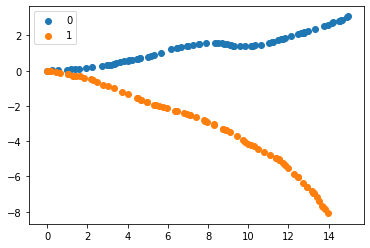

In [5]:
plot_trajectories(*[t[0] for t in training_trajectories[:2]])


In [6]:
# Initialize particle filter network
use_cuda = True #torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

try:
    del pfnet
    torch.cuda.empty_cache()
    print("Deleted old model!")
except:
    pass

torch.autograd.set_detect_anomaly(True)
dynamics = dpf_toy.RobotDynamicsModel()
measurements = dpf_toy.DeepBeaconMeasurementModel()
# measurements = dpf_toy.BeaconMeasurementModel(observer)
pfnet = dpf.ParticleFilterNetwork(dynamics, measurements, 1.0).to(device)

Using device: cuda


In [70]:
# Helpers
def to_torch(x):
    return torch.from_numpy(x.astype(np.float32)).to(device)

# Define optimizer
optimizer = optim.Adam(pfnet.parameters())
def set_lr(lr):
    print("Setting learning rate to", lr)
    for g in optimizer.param_groups:
        g['lr'] = lr

# Training function
def train(training_trajectories, epochs, subsequence_length=20, minibatch_size=10):
    pfnet.train()

    # Some constants
    traj_count = len(training_trajectories)
    minibatches = traj_count // minibatch_size
    state_dim = training_trajectories[0][0].shape[1]
    obs_dim = training_trajectories[0][1].shape[1]
    control_dim = training_trajectories[0][2].shape[1]

    for epoch in range(epochs):
        traj_indices = np.random.choice(traj_count, size=traj_count)
        for traj_minibatch in np.array_split(traj_indices, minibatches):

            # Pull out minibatch trajectories
            minibatch_states = []
            minibatch_observations = []
            minibatch_controls = []
            for i in traj_minibatch:
                traj = training_trajectories[i]
                minibatch_states.append(traj[0])
                minibatch_observations.append(traj[1])
                minibatch_controls.append(traj[2])

            # We assume all of our trajectories have the same length
            traj_length = len(minibatch_observations[0])

            # Generate list of overlapping subsequences
            ## TODO: clean this mess up
            subsequences = []
            start = 0
            end = start + subsequence_length
            while end <= traj_length:
                subsequences.append((start, end))
                start += subsequence_length #// 2
                end = start + subsequence_length
            
            # Initialize some constants...
            # N := number of trajectories in our minibatch
            # M := number of particles
            N = len(minibatch_states)
            M = 1000

            # First, initialize our particle state + weight tensors
            particles = np.zeros((N, M, state_dim))
            log_weights = np.ones((N, M)) * (-np.log(M))
            for i, s in enumerate(minibatch_states):
                # Set all particles to initial state
                particles[i] = np.random.uniform([-1, -1, 0], [1, 1, 0], size=(M, state_dim)) #s[start][np.newaxis,:]

                # TODO: this noise feels like a hack
                #particles[i] += np.random.normal(0, (1, 1, 0.2), size=particles[i].shape)
            particles = to_torch(particles)
            log_weights = to_torch(log_weights)

            # Optimize over each subsequence!
            print(subsequences)
            for start, end in subsequences:
                
                losses = []

                for timestep in range(start, end):
                    # Build observation tensor
                    observations = np.zeros((N, obs_dim))
                    for i, o in enumerate(minibatch_observations):
                        observations[i] = o[timestep]
                    observations = to_torch(observations)
                    
                    # Build control tensor
                    controls = np.zeros((N, control_dim))
                    for i, c in enumerate(minibatch_controls):
                        controls[i] = c[timestep]
                    controls = to_torch(controls)
                    
                    # Build labeled state tensor
                    label_states = np.zeros((N, state_dim))
                    for i, s in enumerate(minibatch_states):
                        # Note the +1 to the index -- this is because we
                        # include t=0 in the state list
                        label_states[i] = s[timestep + 1]
                    label_states = to_torch(label_states)
                    
                    # Propagate through particle filter
                    best_states, particles, log_weights = pfnet.forward(
                        particles, log_weights, observations, controls, resample=False)
                   
                    weight_std = torch.std(log_weights, dim=[1])
                    assert weight_std.shape == (N,)
                    weight_std = torch.mean(weight_std)
                    print(weight_std.cpu().detach().numpy())
                    # Compute loss
                    loss = F.mse_loss(best_states[:,:2], label_states[:,:2])
                    losses.append(loss)
                    
                    # Don't backprop through time
                    particles = particles.detach()
                    log_weights = log_weights.detach()

                loss = torch.mean(torch.stack(losses))

                # Optimize
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                print("Training loss:", loss.cpu().detach().numpy())
            print(">>>>")


In [71]:
set_lr(1e-4)
train(training_trajectories[0:1], epochs=20, subsequence_length=80, minibatch_size=1)

Setting learning rate to 0.0001
[(0, 80)]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Training loss: 2.4116285
>>>>
[(0, 80)]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Training loss: 2.2054813
>>>>
[(0, 80)]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

KeyboardInterrupt: 

In [ ]:
particle_states = to_torch(
    np.random.normal(0., 1., size=(1, 20, 3))
)
observations = to_torch(observer.forward(particle_states[0:1, 0].cpu().numpy()))
measurements(observations, particle_states)

In [1]:
dpf_toy.BeaconMeasurementModel()

NameError: name 'dpf_toy' is not defined

In [ ]:
true_states, observations, controls = training_trajectories[0]
num_particles = 1000
particle_states = torch.FloatTensor(
    [[true_states[0] for _ in range(num_particles)]]).to(device)
particle_weights = torch.ones((1,num_particles)).to(device)

end = 80
states = []
for control, observation in zip(controls[:end], observations[:end]):
    # Type conversions
    observation = to_torch(observation[np.newaxis,:])
    control = to_torch(control[np.newaxis,:])

    # Particle filter network: forward
    best_state, particle_states, particle_weights = pfnet.forward(
        particle_states, particle_weights, observation, control, resample=False)
    # print (np.std(particle_weights.cpu().detach().numpy()), np.mean(particle_weights.cpu().detach().numpy()))

    states.append(best_state.cpu().detach().numpy())
pf_states = np.array(states)
particle_states = particle_states[0].cpu().detach().numpy()
particle_weights = particle_weights[0].cpu().detach().numpy()

In [ ]:
print("Trained network")
print(particle_weights)
plot_trajectories(
    true=true_states,
    pf=pf_states,
    particles=(particle_states, particle_weights),
    beacons=observer.locations
)

In [ ]:
print("Trained network")
plot_trajectories(
    true=true_states,
    pf=pf_states,
    particles=(particle_states[0].cpu().numpy(), particle_weights[0].cpu().numpy()),
    beacons=observer.locations
)